# FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

## Objective:

Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset. 

## Dataset:

The dataset contains historical exchange rate with each column representing a different currency rate over time. The first column indicates the date, and second column represent exchange rates USD to Australian Dollar.


## Part 1: Data Preparation and Exploration

### 1. Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.

In [66]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [67]:
df = pd.read_csv('./exchange_rate.csv')
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


### 2. Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [68]:
# Checking for Null Values
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [69]:
# Checking for Duplicates
df.duplicated().sum()

0

In [70]:
# Checking for dtypes
df.dtypes

date        object
Ex_rate    float64
dtype: object

In [71]:
# Converting date feature to datetime
df['date'] = pd.to_datetime(df['date'])

# Setting Date as index
df.set_index('date', inplace=True)

# Making the date index timezone naive
df.index = df.index.tz_localize(None)

display(df)

,Ex_rate
date,
1990-01-01,0.785500
1990-02-01,0.781800
1990-03-01,0.786700
1990-04-01,0.786000
1990-05-01,0.784900
...,...
2010-06-10,0.718494
2010-07-10,0.721839
2010-08-10,0.723197


### 3. Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.

In [72]:
import matplotlib.pyplot as plt

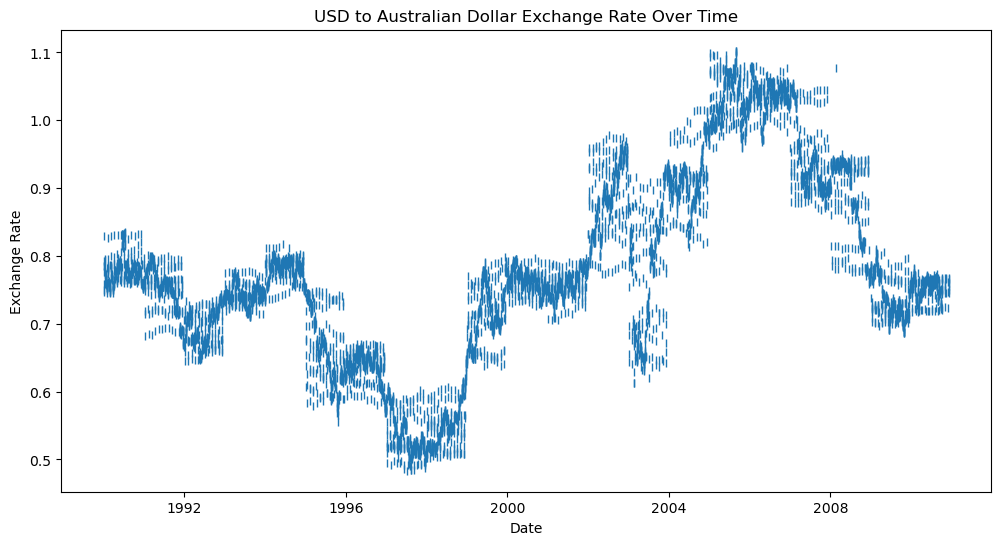

In [73]:
# Ploting the timeseries data
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Ex_rate'], marker='|', linestyle = 'none')
plt.title('USD to Australian Dollar Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.show()

## Part 2: Model Building - ARIMA

### 1. Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.

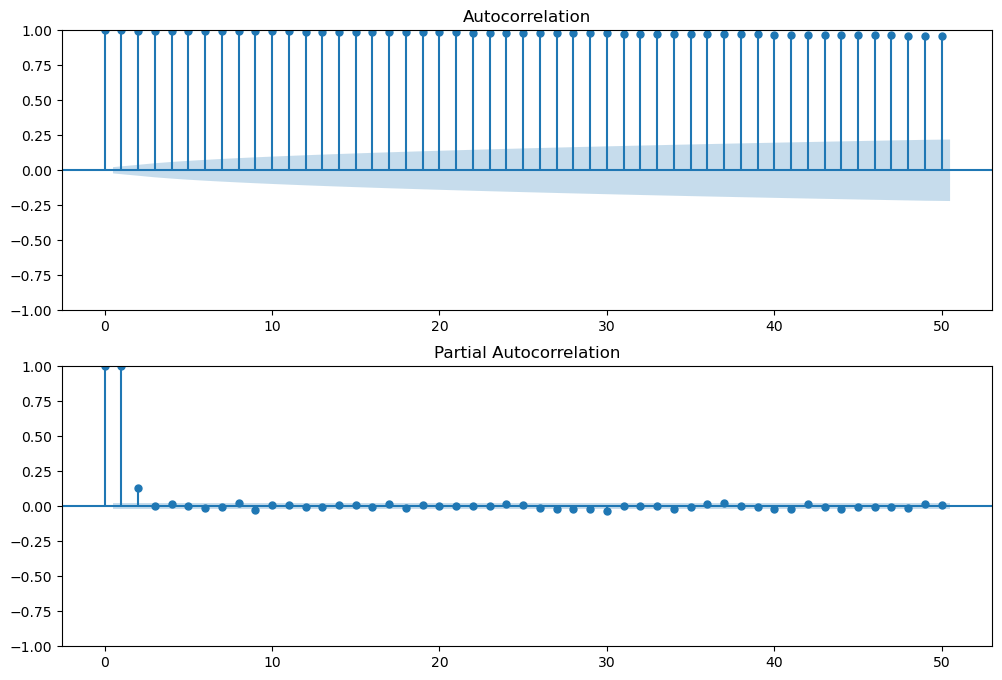

In [74]:
# Selecting Parameter for ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df['Ex_rate'], lags=50, ax=ax[0])
plot_pacf(df['Ex_rate'], lags=50, ax=ax[1])
plt.show()

### 2.Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

In [75]:
# Training Model
from statsmodels.tsa.arima.model import ARIMA

# Setting initial parameters based on ACF and PACF plots
p = 1 # AR term
d = 1 # Differencing term
q = 1 # MA term

# Fitting the ARIMA model
model_arima = ARIMA(df['Ex_rate'], order=(p, d, q))
arima_result = model_arima.fit()

# Printing Model Summary
display(arima_result.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 22 May 2024   AIC                         -56102.322
Time:                        18:00:42   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.000    3.58e-05    3.62e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2865078.33
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3. Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

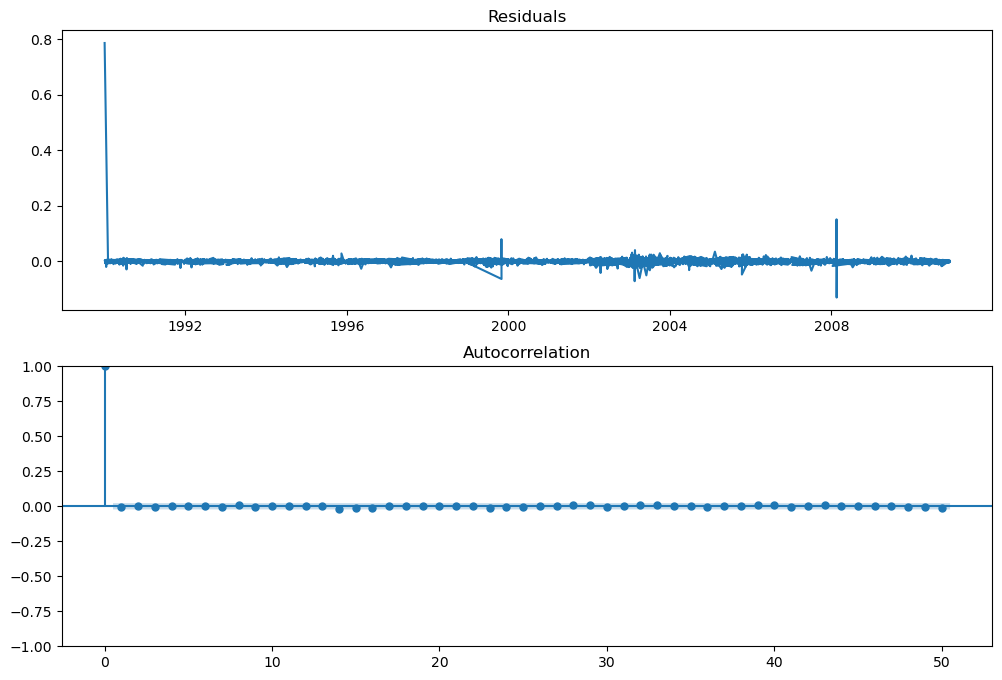

In [76]:
# Residual Analysis
residuals = arima_result.resid

# Ploting Residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(residuals)
ax[0].set_title('Residuals')
plot_acf(residuals, lags=50, ax=ax[1])
plt.show()

### 4. Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

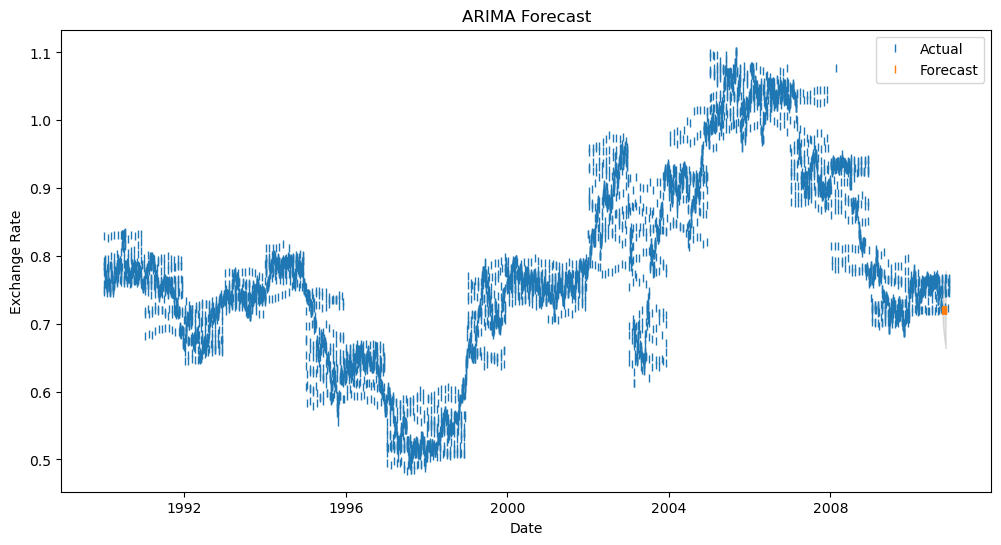

In [77]:
# Forecasting Future Values
forecast = arima_result.get_forecast(steps=30)
forecast_index = pd.date_range(start=df.index[-1], periods=30, freq='D')
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plotting Forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label="Actual", marker='|', linestyle='none')
plt.plot(forecast_index, forecast_values, label='Forecast', marker='|', linestyle='none')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:,1], color='k', alpha=0.1)
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

## Part 3: Model Building - Exponential Smoothing

### 1. Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).

In [78]:
# Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Choosing an appropriate Exponential Smoothing model (Holt-Winters)
model_es = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None, seasonal_periods=365)

# Fitting Model
es_result = model_es.fit()

# Model Summary
display(es_result.summary())

Dep. Variable:,Ex_rate,No. Observations:,7588
Model:,ExponentialSmoothing,SSE,0.273
Optimized:,True,AIC,-77641.009
Trend:,Additive,BIC,-77613.272
Seasonal:,None,AICC,-77640.998
Seasonal Periods:,None,Date:,"Wed, 22 May 2024"
Box-Cox:,False,Time:,18:00:42
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8700395,alpha,True
smoothing_trend,3.9825e-18,beta,True


### 2. Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.

Parameters are already optimized by statsmodels

### 3. Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.

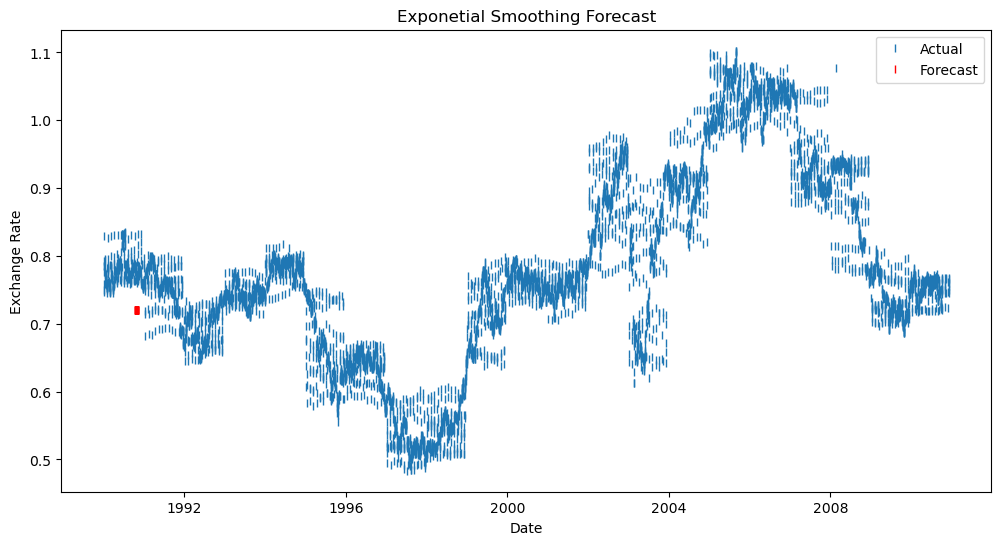

In [80]:
# Training model with exponential smoothing
es_forecast = es_result.forecast(steps=30)

# Plotting forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual', marker='|', linestyle='none')
plt.plot(es_forecast.index, es_forecast, label='Forecast', color='red', marker='|', linestyle='none')
plt.title('Exponetial Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

## Part 4: Evaluation and Comparison

### 1. Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.

In [83]:
# Evaluating results from arima and expotential smoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculating error metrics for ARIMA
arima_forecast_values = forecast_values[:30] # Using only first 30 steps to compare
arima_mae = mean_absolute_error(df['Ex_rate'][-30:], arima_forecast_values)
arima_rmse = mean_squared_error(df['Ex_rate'][-30:], arima_forecast_values, squared=False)
arima_mape = np.mean(np.abs(
    (df['Ex_rate'][-30:] - arima_forecast_values) / df['Ex_rate'][-30:]
)) * 100

# Calculating Error Metrics for Exponential Smoothing
es_mae = mean_absolute_error(df['Ex_rate'][-30:], es_forecast)
es_rmse = mean_squared_error(df['Ex_rate'][-30:], es_forecast, squared=False)
es_mape = np.mean(np.abs(
    (df['Ex_rate'][-30:] - es_forecast) / df['Ex_rate'][-30:]
)) * 100

# Printing Error Metrics
print(f'ARIMA - \nMEA: {arima_mae}, \nRMSE: {arima_rmse}, \nMAPE: {arima_mape}')
print(f'\nExponential Smoothing - \nMAE: {es_mae}, \nRMSE: {es_rmse}, \nMAPE: {es_mape}')

ARIMA - 
MEA: 0.012724006489305202, 
RMSE: 0.016982710912755217, 
MAPE: nan

Exponential Smoothing - 
MAE: 0.012755718241735528, 
RMSE: 0.01700519572211454, 
MAPE: nan


### 2. Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.

#### Comparing Models

##### Performance:

1. MAE (Mean Absolute Error): 
    
    The MAE values are very close, indicating that both models have similar performance interms of the average magnitude of errors in the forecast.

2. RMSE (Root Mean Squared Error):

    The RMSE values are also very close, suggesting that both models perform similarly in terms of the square root of the average of squared errors. RMSE penalized larger errors more than MAE.

3. MAPE (Mean Absolute Percentage Error):

    Both models yielded 'nan' for MAPE. This ususally happens if the actual values have zeros or near-zero values, causing division by zero or very small numbers.

##### Advantages:

ARIMA Model:

* Advantages:
    
    1. Flexibility:

        ARIMA models can capture various types of time series patterns, including trend and seasonality, by differencing and using autoregressive (AR) and moving average (MA) components.

    2. Diagnostics:

        Offers a robust framework for checking model adequacy through residual diagnostics (ACF and PACF of residuals).

    3. Parameter Interpretation:

        The parameters (p,d,q) have clear interpreations in terms of past values and past forecasts errors.

* Limitations:

    1. Complexity:

        Selecting the right parameters (p, d, q) can be challenging and requires careful analysis of ACF and PACF plots.

    2. Computationally Intensive:

        Fitting an ARIMA model, especially for large datasets of high-order models, can be computationally expensive.

    3. Sensitivity to Non-stationarity:

        ARIMA models assume stationarity or require differencing to achieve stationarity, which might not be straightforward for all datasets.

Exponential Smoothing Model:

* Advantages:

    1. Simplicity: 

        Easier to understand and implement compared to ARIMA. Suitable for beginners and for time series without complex patterns.

    2. Smoothing:

        Effective for capturing trends and seasonality without requiring the data to be stationary.

    3. Automatic Optimization:

        Many implementations, such as Holt-Winters, include automatic parameter optimization.

* Limitations:

    1. Limitations Flexibility:

        While good for certain patterns, Exponential Smoothing models may not capture complex timeseries behaviours as well as ARIMA.

    2. Overfitting: There's a risk of overfitting, especially wit models that have many parameters (e.g., Holt-Winters).

    3. Less Robust Diagnostics: Does not have as robust a framework for model diagnositics and checking residuals as ARIMA.

### 3. Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.

Given the close performance in terms of MAE and RMSE, and the practical aspects of implementation and interpretation, the choice between ARIMA and Exponential Smoothing should consider the following:

1. Ease of Use and Interpretaion:

    Exponential Smoothing is simpler to implement and interpret, making it a suitable choice for straightforward forecasting tasks.

2. Flexibility and Robustness:

    ARIMA offers more flexibility and robust diagnostics, making it a better choice if the time series exhibits complex patterns or non-stationary behavior.

##### Conclusion:

Both ARIMA and Exponential Smoothing models yielded similar performance on this dataset. For ease of use and efficiency, Exponential Smoothing is slightly favored, especially for data with clear trends and seasonality.

However, for more complex time series data requiring robust diagnostics and flexibility, ARIMA may provide better performance.
